# Image Segmentation

The main objectives of this module are:

* Use & compare different methods of segmentation:
    * Histogram-based
    * Texture-based
    * Region growing
* Detect objects and extract object features.
* Understand corner detection and basic object recognition

## 1. Histogram segmentation

In histogram segmentation, we make the hypothesis that the histogram is composed of distinct separable distributions, and we try to find the best threshold to separate those distributions.

The code below uses a default threshold of 127 to segment the image. Modify it to:

1. Create a function to compute the optimal threshold for an 8 bit image. Apply on the cameraman image.
1. Compute the Otsu threshold for an 8-bit image, by optimizing within variance or inter-class variance for each possible theshold *t*. See [here](http://nbviewer.jupyter.org/github/odebeir/info-h-500-501/blob/ver_2016-2017/04-Image%20segmentation/01-Histogram%20based%20image%20segmentation.ipynb) how to compute the Otsu threshold.

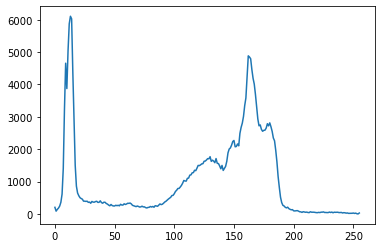

55.09594154333054 162.22702535000064 108
33.93741927471436 155.7344183588072 94
25.060352701468418 153.07614449756255 89
23.449490442192538 152.53210637767813 87
22.904349214644483 152.3350132982852 87
Optimal threshold : 87


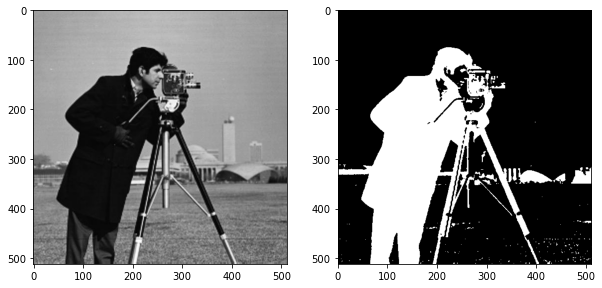

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow

# find optimal threshold in an histogram h from an initial threshold t
def optimal_threshold(h,t):
    # Cut distribution in 2
    g1 = h[:t]
    g2 = h[t:]
    # Compute the centroids
    m1 = (g1*np.arange(0,t)).sum()/g1.sum()
    m2 = (g2*np.arange(t,len(h))).sum()/g2.sum()
    # Compute the new threshold
    t2 = int((m1+m2)/2)
    print(m1,m2,t2)
    
    if( t2 != t ) : return optimal_threshold(h,t2)
    return t2

im = imread('camera.jpg')

h,bins = np.histogram(im,range(257))

plt.figure()
plt.plot(h)
plt.show()

t = optimal_threshold(h,128)
print("Optimal threshold : %d"%t)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(im<t, cmap=plt.cm.gray)
plt.show()

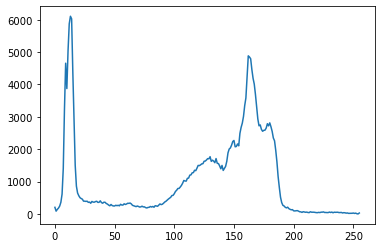

Otsu threshold : 88


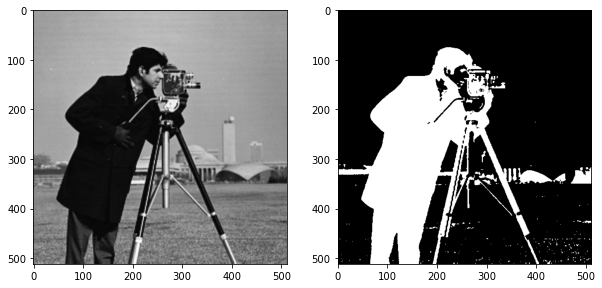

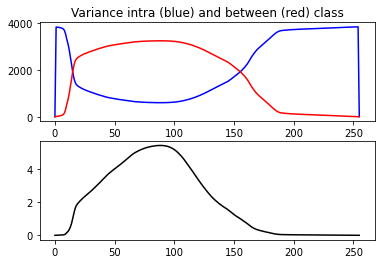

In [2]:
def otsu_threshold(h):
    p = h*1./h.sum() # Probability histogram
    
    # Check every possible threshold
    best_l = 0
    best_t = 0
    
    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    sep = np.zeros(len(h))
    for t in range(1,len(h)-1):
        # Class probabilities
        w0 = p[:t].sum()
        w1 = p[t:].sum()
        # Class means
        m0 = (np.arange(0,t)*p[:t]).sum()/w0
        m1 = (np.arange(t,len(h))*p[t:]).sum()/w1
        # Class variances
        s0 = (((np.arange(0,t)-m0)**2)*p[:t]).sum()/w0
        s1 = (((np.arange(t,len(h))-m1)**2)*p[t:]).sum()/w1
        # Intra-class
        sw = w0*s0+w1*s1
        # Inter-class
        sb = w0*w1*((m1-m0)**2)
        # Separability
        l = sb/sw
        if( l > best_l ):
            best_l = l
            best_t = t
        var_within[t] = sw
        var_between[t] = sb
        sep[t] = l
    
    return best_t, var_within, var_between, sep

im = imread('camera.jpg')

h,bins = np.histogram(im,range(257))
plt.figure()
plt.plot(h)
plt.show()

t,var_within, var_between, sep = otsu_threshold(h)
print("Otsu threshold : %d"%t)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(im<t, cmap=plt.cm.gray)
plt.show()
plt.figure()
plt.subplot(2,1,1)
plt.plot(var_within, 'b-')
plt.plot(var_between, 'r-')
plt.title('Variance intra (blue) and between (red) class')
plt.subplot(2,1,2)
plt.plot(sep, 'k-')
plt.show()

**Need more help? You can check the following videos:**

* [Manual thresholding](https://www.youtube.com/watch?v=rgKkws_fqz4&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=24)
* [Optimal threshold](https://www.youtube.com/watch?v=7B1cs0PARtg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=25)
* [Otsu threshold](https://www.youtube.com/watch?v=mz26bssSLds&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=26)

## 2. Texture segmentation

Texture segmentation uses regional descriptors to segment the image based on the local texture. A simple algorithm is provided below, which:

* Extract neighborhoods with the sliding window method
* Compute the local maximum on the neighborhood and put it in a "descriptor" image
* Use Otsu thresholding on the descriptor image to segment it
* Display the results

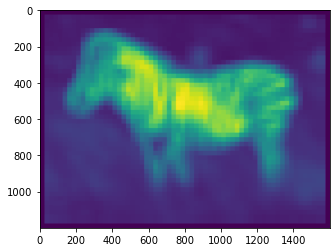

In [3]:
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage.feature import greycomatrix, greycoprops
from skimage.morphology import disk, opening, closing

def texture_descriptor(N):
    displacement = 25
    angles = [0, np.pi/6, np.pi/4, np.pi/3]
    glcm = greycomatrix(N, [displacement], angles, 256)
    return greycoprops(glcm, 'dissimilarity').max()

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

def sliding_window_overlap(im, PATCH_SIZE, STRIDE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, STRIDE):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, STRIDE):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            c = (i+PATCH_SIZE[0]//2, j+PATCH_SIZE[1]//2) # center of the patch
            output[c[0]-STRIDE:c[0]+STRIDE, c[1]-STRIDE:c[1]+STRIDE] = texture_descriptor(patch)
    return output

# Open zebra image as an 8-bit integer grayscale
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

output = sliding_window_overlap(im, (100,100), 25)

plt.figure()
plt.imshow(output)
plt.show()

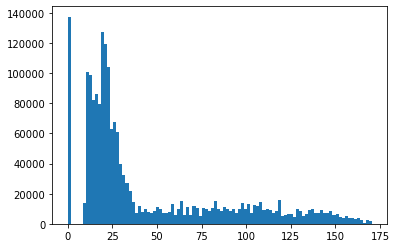

In [4]:
plt.figure()
plt.hist(output.flatten(), bins=100)
plt.show()

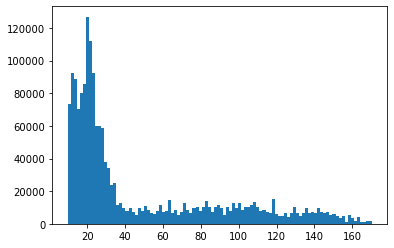

In [5]:
plt.figure()
plt.hist(output[output>0].flatten(), bins=100)
plt.show()

Best threshold: 68.30


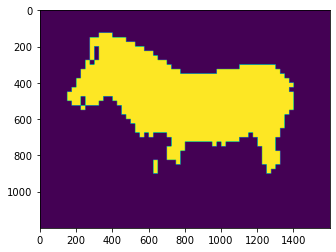

In [6]:
h,bins = np.histogram(output[output>0],bins=100)
t,_,_,_ = otsu_threshold(h)

# t gives the index of the "bin" that was selected as the best threshold. If we want the actual threshold value, 
# we need to take the "center" of the bin:
t = (bins[t]+bins[t+1])/2

print("Best threshold: %.2f"%t)

plt.figure()
plt.imshow(output>t)
plt.show()

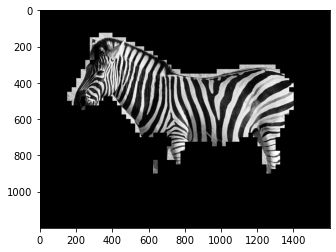

In [7]:
mask = output>t
plt.figure()
plt.imshow(im*mask, cmap=plt.cm.gray)
plt.show()

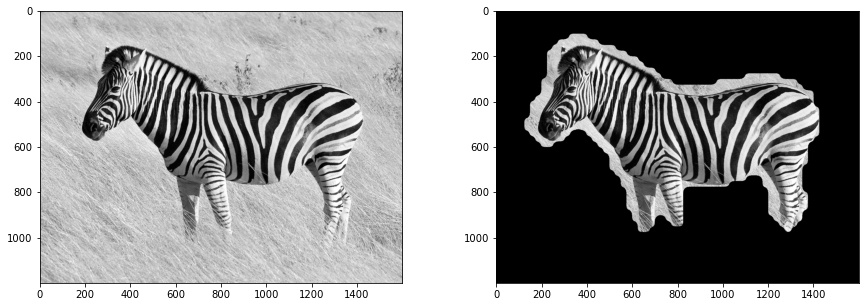

In [8]:
mask = opening(closing(output>40, disk(25)), disk(15))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(im*mask, cmap=plt.cm.gray)
plt.show()

Using the above example as a starting point, replace the "maximum" texture descriptor by properties from the co-occurrence matrix:
* Compute the co-occurrence matrix on the neighborhood (see [greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix)). Test different angles & displacements.
* Test different properties (see [greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops))

Try to segment the zebra image as best as you can using those descriptors.

**Need more help? You can check the following videos:**

* [Region descriptors](https://www.youtube.com/watch?v=5F9aPiab8PA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=27)
* [Properties of the co-occurrence matrix](https://www.youtube.com/watch?v=NR3vrkZ9tyg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=28)
* [Texture segmentation](https://www.youtube.com/watch?v=b-SGhLu-R0c&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=29)

## 3. Region growing

In region growing algorithms, we start from "markers" which act as seed points, and grow the segmented regions from those markers. A well-known region-growing algorithm uses the watershed transform. The example below uses the watershed transform on the cameraman image, with hand-picked markers:

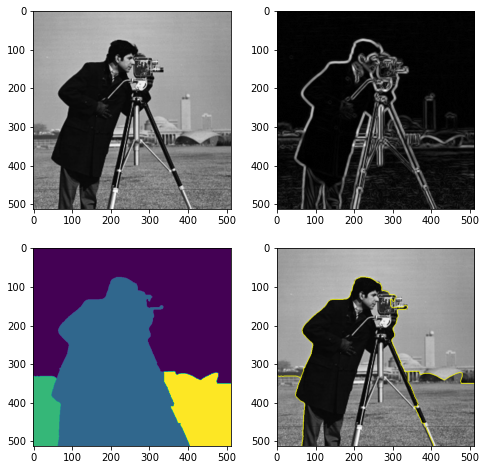

In [9]:
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread

im = imread('camera.jpg')

smoothing_factor = 4
# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

# Hand-picked markers for the road image
markers_coordinates = [
    [10,256], # sky
    [200,150],# cameraman
    [400,20], # grass (left)
    [400,450] # grass (right)
]

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray);
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray);
plt.subplot(2,2,3)
plt.imshow(ws);
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws));

Adapt this method to work on the road image.

Can you find a way to automatically determine the markers?

(659, 960, 3) uint8


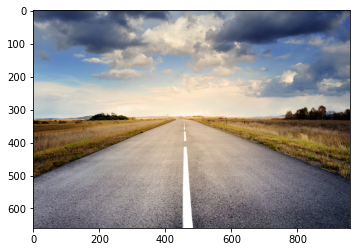

In [10]:
# Your code here
im = imread('road.jpg')
print(im.shape, im.dtype)

plt.figure()
plt.imshow(im)
plt.show()

C:\Users\maxim\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


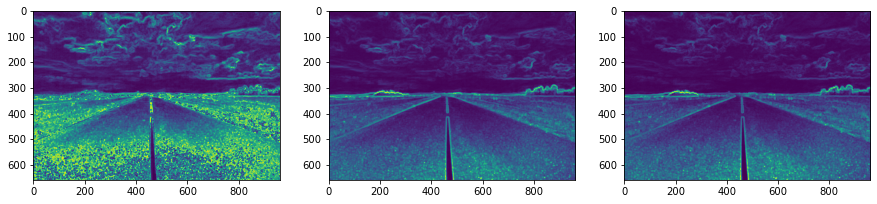

In [11]:
import skimage.filters.rank as skr
from skimage.morphology import disk
from skimage.color import rgb2gray

r = im[:,:,0]
g = im[:,:,1]
b = im[:,:,2]
gr = skr.gradient(r, disk(3))
gg = skr.gradient(g, disk(3))
gb = skr.gradient(b, disk(3))

grad_rgb_sum = gr+gg+gb
grad_rgb_max = np.maximum(np.maximum(gr,gg),gb)
grad_gray = skr.gradient(rgb2gray(im), disk(3))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(grad_rgb_sum)
plt.subplot(1,3,2)
plt.imshow(grad_rgb_max)
plt.subplot(1,3,3)
plt.imshow(grad_gray)
plt.show()

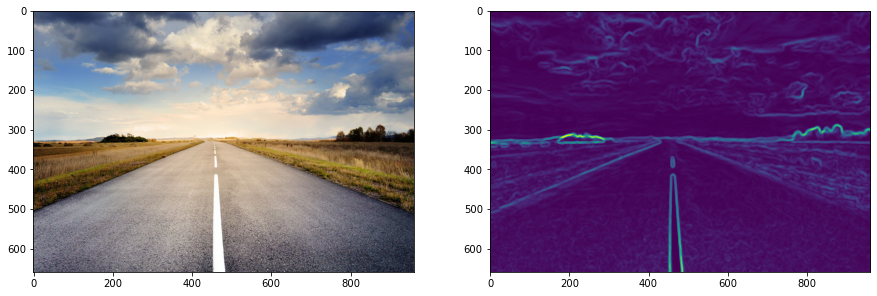

In [12]:
gradient = skr.gradient(skr.median(rgb2gray(im),disk(5)), disk(3))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(gradient)
plt.show()

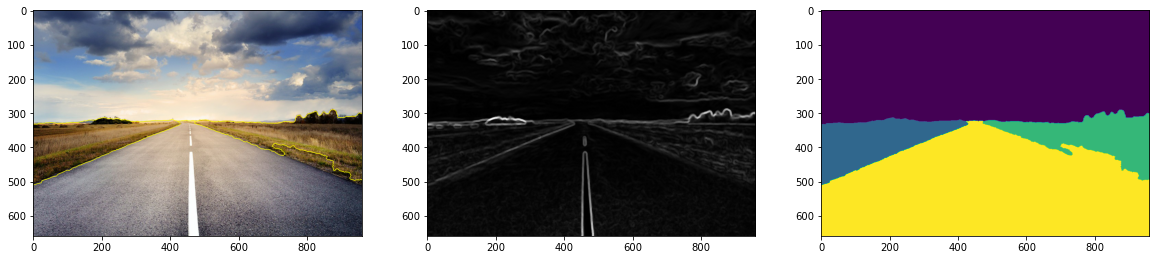

In [13]:
from skimage.segmentation import mark_boundaries, watershed

markers = np.zeros_like(rgb2gray(im))
# Set a few markers
markers[150,500] = 1 #Sky
markers[400,100] = 2 #Grass-left
markers[400,800] = 3 #Grass-right
markers[400,400] = 4 #Road

ws = watershed(gradient, markers)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(mark_boundaries(im,ws))
plt.subplot(1,3,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(ws)
plt.show()

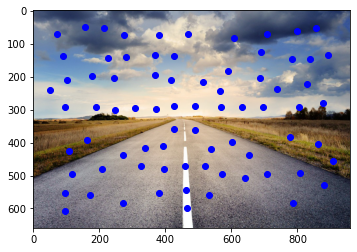

In [14]:
from skimage.feature import peak_local_max

gradient_i = gradient.max()-gradient # inverse gradient image so that local minima -> local maxima
markers_coords = peak_local_max(gradient_i, threshold_rel=0.99, min_distance=50)

plt.figure()
plt.imshow(im)
plt.plot(markers_coords[:,1], markers_coords[:,0], 'bo')
plt.show()

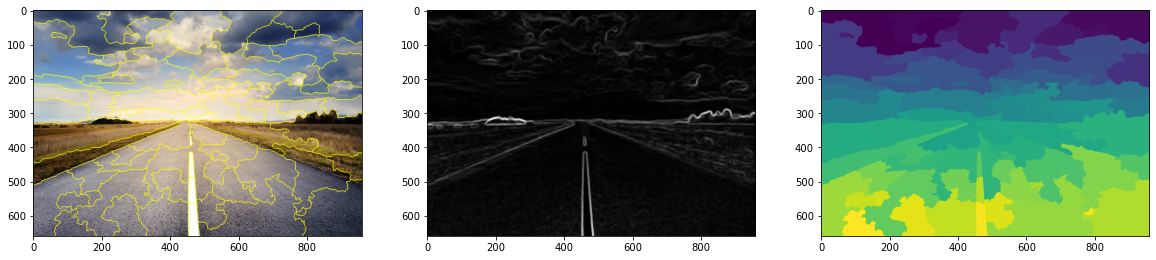

In [15]:
from skimage.measure import label

# create markers image:
markers = np.zeros_like(gradient).astype('bool')
markers[tuple(markers_coords.T)] = True

# label:
markers = label(markers)

# watershed:
ws = watershed(gradient, markers)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(mark_boundaries(im,ws))
plt.subplot(1,3,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(ws)
plt.show()

Another use of the watershed transform is to separate overlapping object, as in the image below.

* Compute the [distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt) of the image.
* Use the result to automatically find good markers.
* Use the watershed transform to separate the three objects.

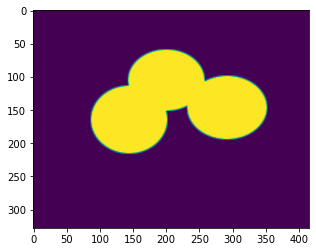

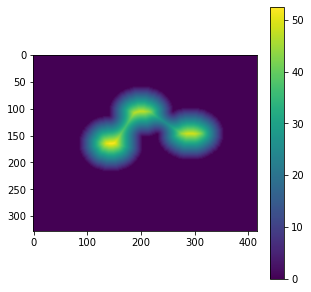

In [16]:
from scipy.ndimage import distance_transform_edt

im = 1-rgb2gray(imread('separ.png'))
plt.imshow(im)


distance = distance_transform_edt(im)
plt.figure(figsize=[5,5])
plt.imshow(distance)
plt.colorbar()
plt.show()

C:\Users\maxim\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


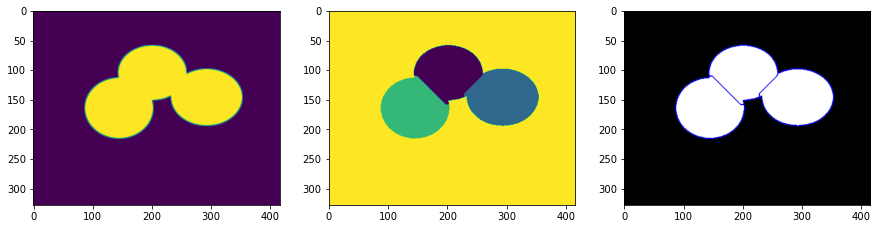

In [17]:
grad = skr.gradient(im,disk(1))

# We can see that the distance map is "noisy", meaning that there might be "false" local minimum.
# We ensure that any local minimum must be at least 20 pixels away from another local minimum to avoid that problem
markers_coords = peak_local_max(distance, min_distance=20)

markers = np.zeros_like(grad).astype('bool')
markers[tuple(markers_coords.T)] = True
markers = label(markers)
markers[im==0] = markers.max()+1

ws = watershed(grad,markers)

plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(im)
plt.subplot(1,3,2)
plt.imshow(ws)
plt.subplot(1,3,3)
plt.imshow(mark_boundaries(im,ws,color=(0,0,1)))
plt.show()

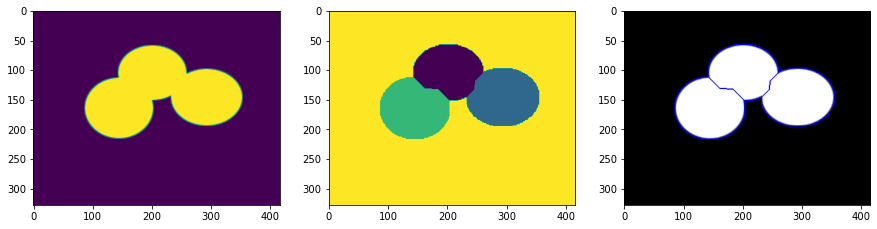

In [18]:
i_distance = distance.max()-distance

ws = watershed(i_distance,markers)

plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(im)
plt.subplot(1,3,2)
plt.imshow(ws)
plt.subplot(1,3,3)
plt.imshow(mark_boundaries(im,ws,color=(0,0,1)))
plt.show()

**Need more help? You can check the following videos:**

* [Markers for region growing](https://www.youtube.com/watch?v=3e0-rE9zhFk&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=30)
* [Watershed transform](https://www.youtube.com/watch?v=GuVp7dlzEKE&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=31)
* [Distance transform](https://www.youtube.com/watch?v=s1eABOdNnVg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=32)

## 4. Object features

The next step after segmentation is often to extract object features in order to recognize, classify, or measure information about the objects.

Starting from the example below:

1. **Extract connected components** (see [label()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=label#skimage.measure.label)) of the shapes image and **display the centroid of the objects** (see [regionprops()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops))
1. For each image label, **extract the coordinates of the contour** (see [find_contours()](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)) and **find the corners** of each objects.
1. Suggest a method to **classify the objects** in different categories.

Number of labeled objects: 19


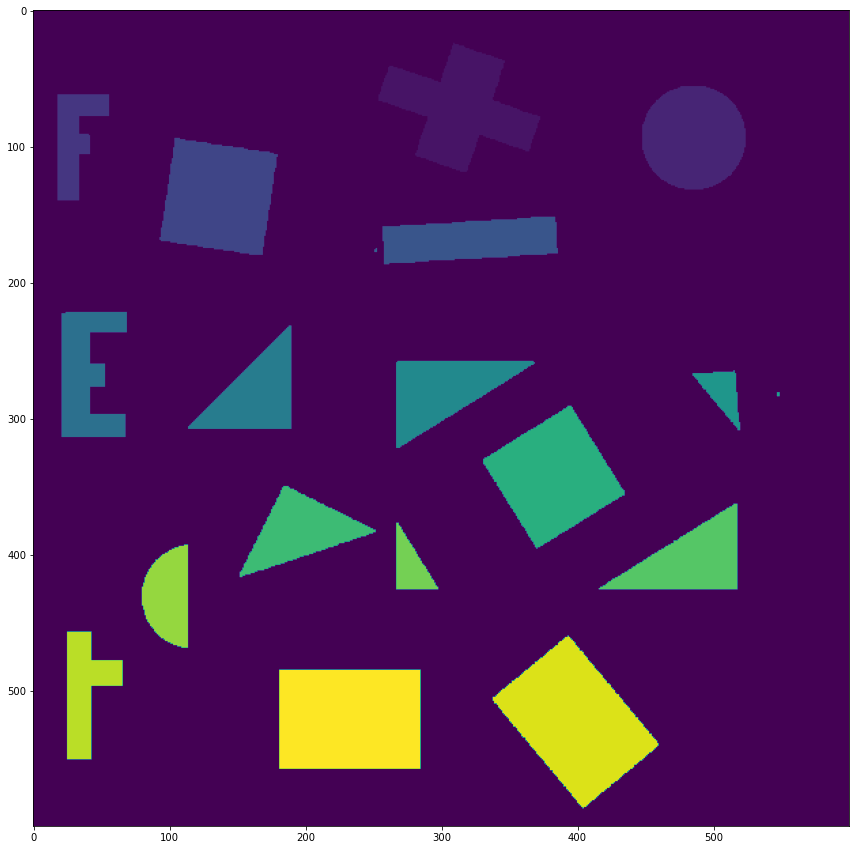

In [19]:
from skimage.measure import label, regionprops,find_contours

im = (imread('shapes.png')[:,:,0]>0).astype(int) #binarize & cast to integer to make it easier to process later
lab = label(im)
print("Number of labeled objects:",lab.max())

plt.figure(figsize=(15,15))
plt.imshow(lab)
plt.show()

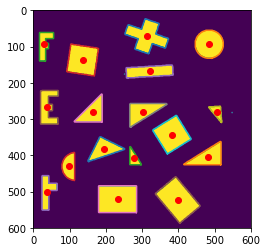

In [20]:
# Your code here
objects = regionprops(lab)

contours = find_contours(im, 0) # find all contours

plt.figure()
plt.imshow(im)
for i,c in enumerate(contours):
    if( objects[i].area < 10 ): continue # Ignore small objects
    plt.plot(c[:,1],c[:,0])
    plt.plot(objects[i].centroid[1], objects[i].centroid[0], 'ro')

# Reset the x-y limits of the graph
plt.ylim([im.shape[0], 0])
plt.xlim([0, im.shape[1]])
plt.show()

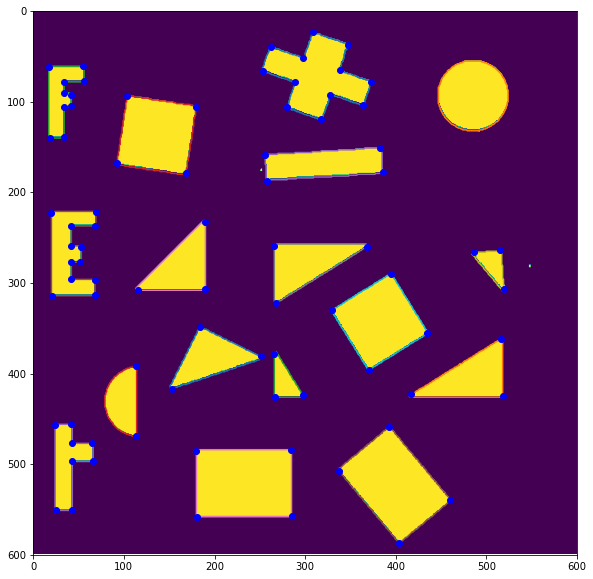

In [21]:
def find_corners(contour):
    dots = np.zeros((len(contour),))

    for i in range(len(contour)):
        before = contour[i-5,:] # negative values will automatically "wrap around" the end of the array
        current = contour[i,:]
        after = contour[(i+5)%(len(contour)-1),:] # however, we have to manually go back to the beginning of the array at the end

        v1 = before-current # "left-border" vector
        v2 = after-current # "right-border" vector
        
        # normalize the vectors:
        v1n = v1/(np.linalg.norm(v1))
        v2n = v2/(np.linalg.norm(v2))
        dots[i] = np.abs(np.dot(v1n,v2n))
    
    # overlap trick
    overlap = 5
    dots_overlap = np.zeros((len(dots)+2*overlap))
    dots_overlap[:overlap] = dots[-overlap:] # copy the end before the beginning
    dots_overlap[-overlap:] = dots[:overlap] # copy the beginning after the end
    dots_overlap[overlap:-overlap] = dots # the original array is in the middle

    lmin = peak_local_max(1-dots_overlap, min_distance=overlap, threshold_abs=0.2)[:,0]
    if( len(lmin) == 0 ): return None # If there are no corners, we don't have to continue

    # Remove overlap
    lmin = (lmin-overlap)%len(dots)

    # Remove peaks that are too close together (which can happen when they have the exact same value)
    keep = np.ones((len(lmin))).astype('bool')
    for i in range(len(lmin)-1):
        if( np.abs(lmin[i+1]-lmin[i]) < overlap ): keep[i+1] = False
    
    lmin = lmin[keep]

    # Get the corners
    return contour[lmin]

plt.figure(figsize=(10,10))
plt.imshow(im)

for i,c in enumerate(contours):
    if( objects[i].area < 10 ): continue # Ignore small objects
    plt.plot(c[:,1],c[:,0])
    # find corners
    corners = find_corners(c)
    if corners is None: continue # if there are no corners, go to the next contour
    plt.plot(corners[:,1], corners[:,0], 'bo')

# Reset the x-y limits of the graph
plt.ylim([im.shape[0], 0])
plt.xlim([0, im.shape[1]])
plt.show()

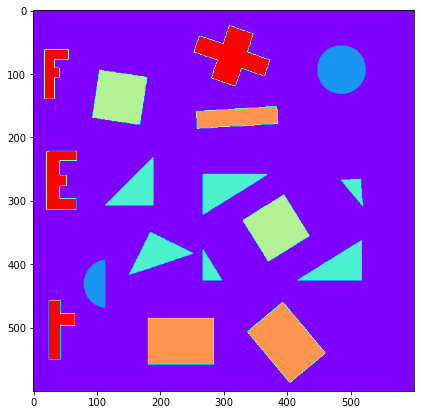

In [22]:
CLASS_ROUNDED = 1
CLASS_TRIANGLE = 2
CLASS_SQUARE = 3
CLASS_RECTANGLE = 4
CLASS_COMPLEX = 5

def classify(obj, contour):
    corners = find_corners(contour)
    if corners is None: return CLASS_ROUNDED
    if( len(corners) < 3 ): return CLASS_ROUNDED
    elif( len(corners) == 3 ): return CLASS_TRIANGLE
    elif( len(corners) == 4 ):
        if( obj.eccentricity < 0.1 ): return CLASS_SQUARE
        else: return CLASS_RECTANGLE
    else: return CLASS_COMPLEX

im_classif = np.zeros(im.shape)
for i in range(len(objects)):
    obj = objects[i]
    if( obj.area < 10 ): continue # ignore small objects
    
    contour = contours[i] # get the contour
    obj_class = classify(obj, contour)
    im_classif[lab==obj.label] = obj_class

plt.figure(figsize=(7,7))
plt.imshow(im_classif, cmap='rainbow')
plt.show()

**Need more help? You can check the following videos:**

* [Object labeling & features](https://www.youtube.com/watch?v=7bOH4E7c8gU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=33)

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

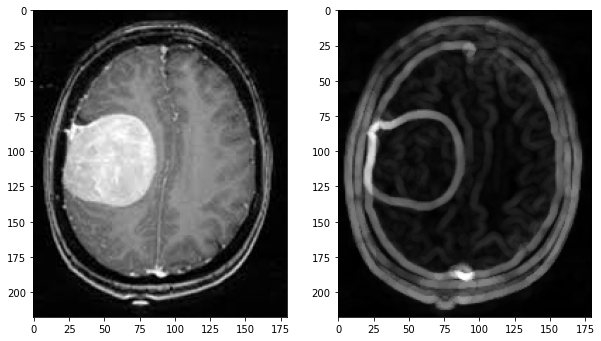

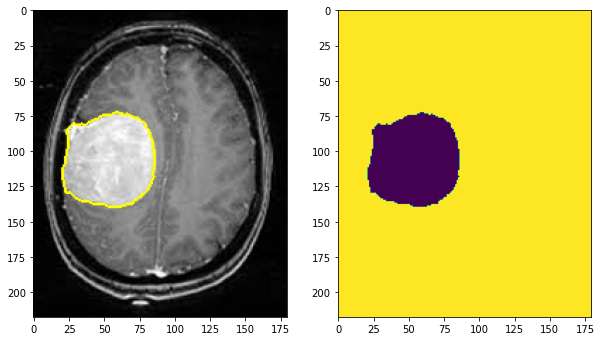

The area of the tumor is approximately of :  405.26 cm^2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage import img_as_ubyte
from skimage.io import imread, imshow
from skimage.morphology import disk

#This function returns a list of tuples corresponding to the position of several pixels that correspond to the region of the tumor.
#To determine whether a region could correspond to the tumor, we check in each direction with a step of 10 if a pixel has a value between 255 and 220,
#in which case the pixel position will be added to the list
def get_possible_locations(im):
    positions = []
    counter = 0
    for i in range(0, im.shape[0], 10):
        for j in range(0, im.shape[1], 10):
            if im[i,j] <= 255 and im[i,j] > 220:
                counter += 1
                positions.append((i,j))
    return positions

#This function returns the center position of each region returned by get_possible_locations()
def local_centers(possible_locations):
    minX = possible_locations[0][0]
    minY = possible_locations[0][1]
    maxX = minX
    maxY = minY
    compX = minX
    centers = []
    for i in range(1, len(possible_locations)):
        if possible_locations[i][0] > compX + 10:
            centers.append(((minX+maxX)//2, (minY+maxY)//2))
            minX = possible_locations[i][0]
            maxX = minX
            minY = possible_locations[i][1]
            maxY = minY
        if possible_locations[i][0] > maxX:
            maxX = possible_locations[i][0]
        if possible_locations[i][1] > maxY:
            maxY = possible_locations[i][1]
        if possible_locations[i][1] < minY:
            minY = possible_locations[i][1]
        compX = possible_locations[i][0]
    centers.append(((minX+maxX)//2, (minY+maxY)//2))
    return(centers)

#This function returns an estimation of the area of the tumor
def estimate_area(ws, index):
    counter = 0
    for i in range(ws.shape[0]):
        for j in range(ws.shape[1]):
            if ws[i, j] == index:
                counter += 1
    return (counter*0.115)

#Opening the mri_brain image as a grayscale image
im = img_as_ubyte(imread('mri_brain.jpg', as_gray=True))

#Compute the gradient of the image and display it
gradient = skr.gradient(skr.median(im,disk(3)), disk(3))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(gradient, cmap=plt.cm.gray)
plt.show()

#Compute the possible locations as well as their center
location = get_possible_locations(im)
center = local_centers(location)

#Return an array of zeros with the same shape and type as im
markers = np.zeros_like(im)

#Placing the markers
#The background will also be applied
for i in range(len(center)):
    markers[center[i][0],center[i][1]] = i+1
markers[0,0] = len(center)+1

ws = watershed(gradient, markers)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(im,ws))
plt.subplot(1,2,2)
plt.imshow(ws)
plt.show()

#Compute the estimation of the tumor area
area = estimate_area(ws, 1)
print('The area of the tumor is approximately of : ', area, 'cm^2')